<div align="center">
<img src="logo/logo.gif" alt="pycpt logo" width="100"/><p style="line-height: 1.1;"><br><strong>PyCPT</strong><br>Color Palette Tables from <a href="http://seaviewsensing.com/pub/cpt-city/" target="_blank">cpt-city</a><br>in your Python environment.<br>Made in 2025 by Léonard Seydoux</p><br clear="all"/>
</div>

## What is cpt-city?

CPT is short for Color Palette Table, a file format popularized by the [Generic Mapping Tools](https://www.generic-mapping-tools.org/) (GMT) for defining colormaps as piecewise-constant color bands between numeric boundaries.

The [cpt-city](http://seaviewsensing.com/pub/cpt-city/) website maintained by J. J. Green is a community-curated archive of color palettes collected from many projects (e.g., GMT, cmocean, Matplotlib, and more). Palettes are organized in family folders and typically include metadata files like `DESC.xml` and `COPYING.xml` that describe provenance and licensing.

## Using this package

This package is shipped with a `cpt-city/` directory that contains the entire archive obtained from the website. The archive can be rebuilt with the `pycpt.update_bundle()` method. Be mindful that individual palettes may carry different licenses-refer to the accompanying `COPYING.xml` files. This archive only contains palettes for which redistribution is permitted. Learn more at on the [cpt-city](http://seaviewsensing.com/pub/cpt-city/) website.

## Installation

The simplest way to install PyCPT is via pip:

## Quickstart

This package parses common CPT formats (including GMT-style lines) and exposes a simple `Palette` API that you can read from a CPT file with the name of a palette from the bundled `cpt-city/` folder, or a path to any CPT file. The reader supports flexible path resolution: you can pass either an absolute/relative file path, or a short name underneath a bundled `cpt-city/` data folder (extensionless is fine, `.cpt` is added automatically).
Once loaded, the `Palette` object provides several useful attributes and methods, such as:
- `palette.cmap` to be used with Matplotlib plotting functions
- `palette.norm` to preserve original CPT boundaries

And many helpers to inspect, scale and interpolate the palette, or plot colorbars and previews. The following sections illustrate some of these features.

In [1]:
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np
import pycpt

### Reading a CPT file

The method `pycpt.read` accepts either a short name relative to the bundled cpt-city archive (e.g., "cmocean/algae", "cl/fs2010", or simply "algae" when unique), or a file path on disk. The file extension (.cpt) is optional and added automatically. 

You can also set the logical palette type with `kind` ("sequential" or "diverging"). If divering is selected, the later scaling is centered around the diverging point (default 0).

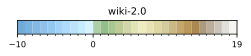

In [ ]:
palette = pycpt.read("wiki-2.0", kind="diverging", diverging_point=0)
palette.plot()

You can load palettes from many families (e.g., `cmocean`, `xkcd`, `gmt`, `wkp`, …). Later in this notebook, we’ll list an entire family with `pycpt.files.get_family(...)` and preview each palette quickly.

Below we switch to another palette and preview its bands.

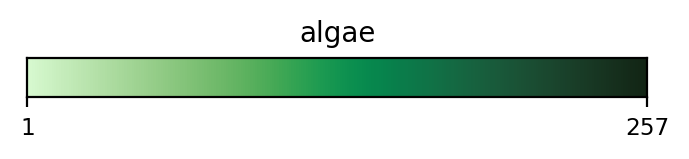

In [3]:
palette = pycpt.read("cmocean/algae")  # also work with "algae"
palette.plot()

## Using the colormap in Matplotlib

There are two common ways to apply a palette:
- Using only `cmap` lets Matplotlib rescale colors to your data range (smooth but may shift intended boundaries).
- Using `cmap` together with `palette.norm` preserves the original CPT boundaries (discrete bands at the authored values).

In the next code cell, the three panels show:
1) Left: `cmap` only (colors are rescaled to the data range).
2) Middle: `cmap + norm` (colors follow original boundaries).
3) Right: Same palette after `palette.scale(vmin, vmax)` and `palette.interpolate(n=...)`, then used with `cmap + norm` and a matching colorbar via `palette.colorbar(...)`.

Tip: For diverging data centered at a value, read with `kind="diverging"` and pass the center to `palette.scale(vmin, vmax, at=center)` so left/right segments preserve their balance.

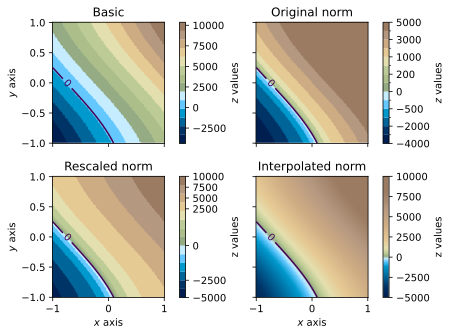

In [89]:
# Create data
x = y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y)
z = 4000 * (x + np.sin(y) + 0.5) + 1000
sea_level = 0

# Get colormap and norm from palette
cpt = pycpt.read("colombia", kind="diverging")

# Create figure
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = ax.flatten()

# Without norm
vals = ax[0].pcolormesh(x, y, z, cmap=cpt.cmap, rasterized=True)
fig.colorbar(vals, ax=ax[0], label="$z$ values", pad=0.1)
ax[0].clabel(ax[0].contour(x, y, z, levels=[sea_level]), [sea_level])

# With norm
vals = ax[1].pcolormesh(x, y, z, norm=cpt.norm, cmap=cpt.cmap, rasterized=True)
fig.colorbar(vals, ax=ax[1], label="$z$ values", pad=0.1, norm=cpt.norm)
ax[1].clabel(ax[1].contour(x, y, z, levels=[sea_level]), [sea_level])

# With norm
cpt.scale(-5000, 10000)
ax[2].pcolormesh(x, y, z, norm=cpt.norm, cmap=cpt.cmap, rasterized=True)
cpt.colorbar(ax=ax[2], label="z values", pad=0.1)
ax[2].clabel(ax[2].contour(x, y, z, levels=[sea_level]), [sea_level])

# Interpolated norm
cpt.interpolate(257)
ax[3].pcolormesh(x, y, z, norm=cpt.norm, cmap=cpt.cmap, rasterized=True)
cpt.colorbar(ax=ax[3], label="z values", pad=0.1)
ax[3].clabel(ax[3].contour(x, y, z, levels=[sea_level]), [sea_level])

# Labels
ax[0].set(title="Basic", ylabel="$y$ axis")
ax[1].set(title="Original norm")
ax[2].set(title="Rescaled norm", xlabel="$x$ axis", ylabel="$y$ axis")
ax[3].set(title="Interpolated norm", xlabel="$x$ axis")

fig.tight_layout()
plt.show()

## Example with an actual digital elevation model

Text(0.5, 1.0, 'La Réunion Island with illumination')

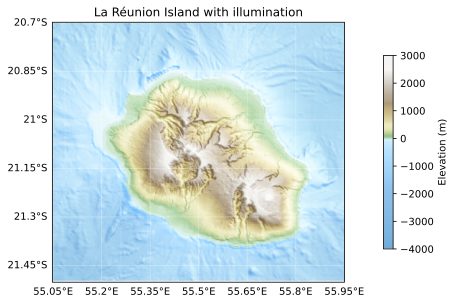

In [ ]:
import cartopy.crs as ccrs

from matplotlib.colors import LightSource
from pygmrt.tiles import download_tiles
from scipy.ndimage import gaussian_filter

# La Réunion Island topography and bathymetry
tiles = download_tiles(bbox=[55.05, -21.5, 55.95, -20.7], resolution="low")
topo = tiles.read(1)
bbox = tiles.bounds
extent = (bbox.left, bbox.right, bbox.bottom, bbox.top)

# Palette
palette = pycpt.read("wiki-france", kind="diverging")
palette.scale(-4000, 3000)
palette.interpolate(257)

# Create figure
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Hillshade
sun = LightSource(azdeg=45, altdeg=50)
shaded = sun.shade(
    topo,
    cmap=palette.cmap,
    norm=palette.norm,
    vert_exag=0.02,
    blend_mode="soft",
)

# Show
ax.imshow(shaded, extent=extent, transform=ccrs.PlateCarree())

# Extra map features
gridlines = ax.gridlines(draw_labels=True, color="white", alpha=0.3)
gridlines.top_labels = False
gridlines.right_labels = False
palette.colorbar(ax=ax, label="Elevation (m)", pad=0.1, shrink=0.5)
ax.set_title("La Réunion Island with illumination")

plt.show()

## Listing and previewing a palette family

`pycpt.files.get_family(name)` returns all CPT files under a given family. This is handy to browse a collection and quickly preview each palette’s discrete bands.

Below, we grid a few palettes from the `wkp` family and call `palette.plot` on each. Unused axes are hidden for clarity.

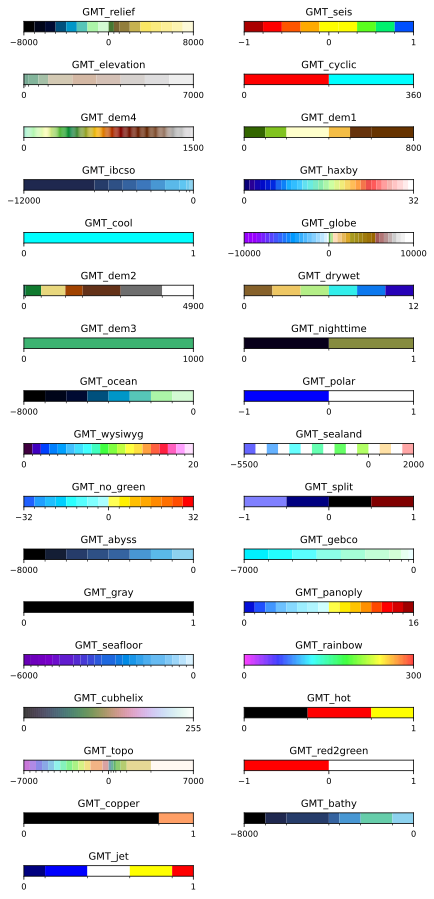

In [30]:
# List all GMT palettes
files = pycpt.get_family("gmt")

# Plot all palettes in a grid
n_cols = 2
n_rows = int(np.ceil(len(files) / n_cols))
fig, axes = plt.subplots(
    figsize=(7, n_rows / 1.1),
    ncols=n_cols,
    nrows=n_rows,
    gridspec_kw={"wspace": 0.3, "hspace": 4},
)
axes = axes.ravel()

# Plot
for ax, filepath in zip(axes, files):
    pycpt.read(filepath).plot(ax=ax)

# Clear unused axes
for j in range(len(files), len(axes)):
    axes[j].axis("off")

plt.show()

## About the archive

The files from the [cpt-city](http://seaviewsensing.com/pub/cpt-city/) website are bundled in the `cpt-city/` folder. You can also download the latest archive from [here](http://seaviewsensing.com/pub/cpt-city/pkg/cpt-city-cpt-2.27.zip) and extract it to replace the existing folder.

Alternatively, there is a helper function `pycpt.files.update_bundle()` that downloads and extracts the latest archive automatically.

In [3]:
pycpt.update_bundle()

## Contribution

Contributions are welcome! Please refer to the `CONTRIBUTING.md` file for guidelines on how to contribute to this project.

This notebook was generated with the `nbconvert` tool. To regenerate it, run: